# Loading Data

In [1]:
# Libraries
import pandas as pd
import numpy as np

import scipy.io as sio

import matplotlib.pyplot as plt

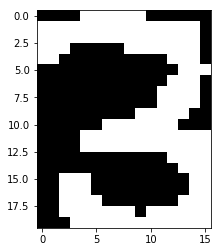

In [2]:
# Loading Data 
mat_contents = sio.loadmat('./Data/binaryalphadigs.mat')
plt.imshow(mat_contents['dat'][3][0], cmap='gray')

In [3]:
def lire_alphaDigits(class_labels, all_data):
    """
        The following function aims to extract from our dataset the part corresponding the class_labels that we 
        wish to extract. It also help put in order the output matrix to be directly used with our algorithm.
        
        ---
        Parameters:
            class_labels : n_array (n, )
                            A vector containing the labels that we wish to extract
            all_data : matrix
                            Our data set (In the form of a Dictionnary -- extracted from a Matlab Matrix(.mat))
        
        ---
        Attributes:
            
    """
    
    
    final = []
    for elements in class_labels:
        temp = np.array([all_data[elements][i].flatten() for i in range(len(all_data[elements]))])
        final.append(temp)

    return np.concatenate(final)

# RBM Initialization

In [4]:
q = 100
p = 320
class RBM():
    
    """
    This class represents our Restricted Boltzman Machine Structure. It contains the differents weights and biais
    for both layers that we will be using. 
    
    
    ---
    Parameters:
        p : int (1,)
            The number of neurons in the first layer representing the Latent variables
            
        q : int (1,)
            The number f neurons in the second layer representing the Hidden variables
    
    """
    def __init__(self, p, q):
        self.W = np.random.normal(0, 0.01, (p, q))
        self.a = np.zeros(p)
        self.b = np.zeros(q)
        
    def update_values(self, val):
        
        """
        This function aims to help updating the different parameters during the training part. 
        The user have to give as an input a vector of values to be updated (In our case, it's gonna be 
        the gradient)
        
        --- 
        Parameters :
            val : vector (3,)
                    Containing the correspondant value to be updated (The gradient in respect to each parameter)
        
        """
        
        self.W += val[0]
        self.a += val[1]
        self.b += val[2]
        
    def print(self):
        print(self.W, self.a, self.b)

In [5]:
def entree_sortie_RBM(RBM, donnee):
    """
    This function returns the output value of each part of our layer.
    We recall that we have found in the theoritical computation that : 
    P(h_j = 1 | v) = sigm(b_j + \sum{w_{i,j} v_i}) with v being our observed variables and h our latent variables
    and w the matrix of weights and the biais of the first output layer.
    
    ---
    Parameters:
        RBM : class
                Our RBM structure that was previously coded as our class
        donnee : 
                Our data
    
    """
    
    sortie = 1 / (1 + np.exp(- RBM.b.reshape(1,-1) - donnee @ RBM.W ))
    
    return sortie

In [6]:
def sortie_entree_RBM(RBM, donnee):
    
    """
    This function returns the output value of each part of our layer.
    We recall that we have found in the theoritical computation that : 
    P(v_i = 1 | h) = sigm(a_i + \sum{w_{i,j} h_j}) with v being our observed variables and h our latent variables
    and w the matrix of weights and the biais of the first output layer.
    
    ---
    Parameters:
        RBM : class
                Our RBM structure that was previously coded as our class
        donnee : 
                Our data
    
    """
    
    entree = 1 / (1 + np.exp(- RBM.a.reshape(1,-1) - donnee @ RBM.W.T))
                  
    return entree

In [7]:
def train_RBM(RBM, x, iter_gradient, epsilon, batch_size, verbose = False):
    
    """
        This function aims to compute the training part of our algorithm. 
        We recall that the goal is to maximize our Maximum-Vraisemblance, we first start by computing the gradient
        in respect to each parameter and then use an optimization approch to update our parameters. 
        
        We will be using the Gibbs Sampling approach to estimate the second term of the gradient which is related
        to the expectancy. 
        
        
        ---
        Parameters:
            RBM :
                    Our RBM structure
            x : matrix (num_of_samples, p)
                    Our Observed variables (It will be the result of the lire_alphaDigits function 
                    that was previously coded)
                
            iter_gradient: int (1, )
                    The number of iteration during the optimization process
            
            epsilon : int (1, )
                    The learning rate 
                    
            batch_size : int (1,)
                    The batch size to be used during the training
                    
            verbose : BOOL
                    Parameter controlling weather the user want to output the values during the optimization part.
            

    """
    
    p,q = RBM.W.shape
    n = x.shape[0]
    for i in range(iter_gradient):
        x_copy = x.copy()
        np.random.shuffle(x_copy)
        
        for batch in range(0, n, batch_size):
            
            v_0 = x_copy[batch : min(batch + batch_size, n), :]
            h_0 = (np.random.uniform(size = (len(v_0), q)) < entree_sortie_RBM(RBM, v_0)).astype('float')
            v_1 = (np.random.uniform(size = (len(v_0), p)) < sortie_entree_RBM(RBM, h_0)).astype('float')
            
            # Gradient compilation
            d_a = np.sum(v_0 - v_1, axis = 0)
            d_b = np.sum(entree_sortie_RBM(RBM, v_0) - entree_sortie_RBM(RBM, v_1), axis = 0)
            d_W = np.dot(v_0.T, entree_sortie_RBM(RBM, v_0)) - np.dot(v_1.T, entree_sortie_RBM(RBM, v_1))
            
            cst = epsilon/len(v_0)
            RBM.update_values([cst * d_W, cst * d_a, cst *d_b])
        
        sortie = entree_sortie_RBM(RBM, x_copy)
        new_data = sortie_entree_RBM(RBM, sortie)
        erreur = np.linalg.norm(x_copy - new_data, ord='fro')**2 / x_copy.size
        if verbose:
            print(erreur)
    return RBM

In [8]:
def generate_image_RBM(RBM, nb_images, nb_iter):
    
    """
    Using our RBM, the following function uses the different weights that were already updated to generate new 
    samples. 
    
    ---
    Parameters:
        RBM : 
                Our RBM class with the weights already trained and updated
        nb_images : int (1,)
                The number of samples that we want to generate
                
        nb_iter : int (1,)
                The number of iterations used during the generation
    
    """
    
    p,q = RBM.W.shape
    for i in range(nb_images):
        x = (np.random.uniform(size=p) < 0.5).astype('float')
        
        for iter in range(nb_iter):
            h = (np.random.uniform(size = q) < entree_sortie_RBM(RBM, x)).astype('float')
            x = (np.random.uniform(size = p) < sortie_entree_RBM(RBM, h)).astype('float')
        
        x =  np.reshape(x, (20, 16))
        plt.imshow(x, cmap = 'gray')
        plt.show()

# Generating Samples

In [14]:
x = lire_alphaDigits([3], mat_contents['dat'])
iter_gradient = 1000
epsilon = 0.1
batch_size = 3
rbm = RBM(320, 100)
rbm = train_RBM(rbm, x, iter_gradient, epsilon, batch_size, verbose = False)

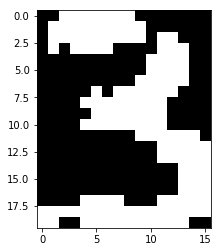

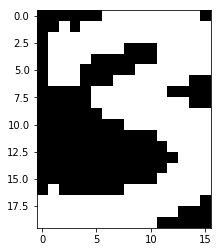

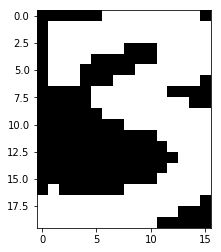

In [15]:
generate_image_RBM(rbm, 3, 1000)

# Using the RBM Class Implementation

In [16]:
from RBM import RBM

In [17]:
x = lire_alphaDigits([3], mat_contents['dat'])
iter_gradient = 1000
epsilon = 0.1
batch_size = 3
rbm = RBM(320, 100)
rbm.fit(x, iter_gradient, epsilon, batch_size, verbose = False)

Training successfully over.


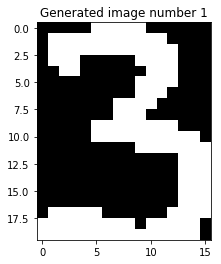

In [18]:
rbm.generate_image(1, 1000)